<img src="https://s3.amazonaws.com/weclouddata/images/logos/wcd_logo_new_2.png" width="10%">
<h1><center>Computer Vision Project Template (Image Classification)</center></h1>

---

For this notebook, we will be using the Project Template.

The goal of the template is to make the Capstone Project implementation easy for the user.

# ML Project

There are 5 core components of a ML Project:
- Problem Statement
- Dataset
- DL Model
- Model Training
- Model Evaluation

The Template provides wrappers (Data and Model classes) and an API (ModelEngine) that works hand-in-hand with a Configuration. Together, they form a complete Training API.


Download and install the template

In [1]:
# !git clone https://github.com/jjaskirat/wcd_project_template.git
# %cd wcd_project_template
# ! python setup.py install
# %cd ..

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

%matplotlib inline

Imports

In [3]:
import time
import os
import copy
from typing import Optional

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import random
from sklearn.model_selection import train_test_split
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

/opt/conda/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Problem Statement

---

Aircraft, and in particular airplanes, are alternative to objects typically considered for fine-grained categorization such as birds and pets. There are several aspects that make aircraft model recognition particularly interesting. Firstly, aircraft designs span a hundred years, including many thousand different models and hundreds of different makes and airlines. Secondly, aircraft designs vary significantly depending on the size (from home-built to large carriers), destination (private, civil, military), purpose (transporter, carrier, training, sport, fighter, etc.), propulsion (glider, propeller, jet), and many other factors including technology. One particular axis of variation, which is is not shared with categories such as animals, is the fact that the structure of the aircraft changes with their design (number of wings, undercarriages, wheel per undercarriage, engines, etc.). Thirdly, any given aircraft model can be re-purposed or used by different companies, which causes further variations in appearance (livery). These, depending on the identification task, may be consider as noise or as useful information to be extracted. Finally, aircraft are largely rigid objects, which simplifies certain aspects of their modeling (compared to highly-deformable animals such as cats), allowing one to focus on the core aspects of the fine-grained recognition problem.

## Dataset

---

**Content**

The dataset contains 10,000 images of aircraft, The data is split into 3334 training images, 3333 validation and 3333 testing images
Aircraft models are organized in a four-levels hierarchy. The four levels, from finer to coarser, are:

Model, e.g. Boeing 737-76J. Since certain models are nearly visually indistinguishable, this level is not used in the evaluation.
Variant, e.g. Boeing 737-700. A variant collapses all the models that are visually indistinguishable into one class. The dataset comprises 100 different variants.
Family, e.g. Boeing 737. The dataset comprises 70 different families.
Manufacturer, e.g. Boeing. The dataset comprises 41 different manufacturers.

**csv files**

the csv files makes easy way to use the dataset. By Separate dataset into 3 file that is train,val and test
It contains 3 columns:
filename: image file name
Classes: Variant Classes name e.g. 707-320, A318
Labels: Categorical Value for the Classes that is 0-99 for 100 Classes

**Acknowledgements**

Data source: http://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/
Please use the following citation when referring to this dataset:

Fine-Grained Visual Classification of Aircraft, S. Maji, J. Kannala, E. Rahtu, M. Blaschko, A. Vedaldi, arXiv.org, 2013

Download the dataset from Kaggle

In [4]:
import kagglehub

# Download latest version
data_dir = kagglehub.dataset_download("seryouxblaster764/fgvc-aircraft")

print("Path to dataset files:", data_dir)
print("Contents of Data Dir: ", os.listdir(data_dir))

Path to dataset files: /root/.cache/kagglehub/datasets/seryouxblaster764/fgvc-aircraft/versions/2
Contents of Data Dir:  ['val.csv', 'fgvc-aircraft-2013b', 'train.csv', 'test.csv']


In [5]:
# Show the img_dir

img_dir = f'{data_dir}/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images'
print("Contents of Img Dir: ", os.listdir(img_dir)[:5])

Contents of Img Dir:  ['2104253.jpg', '2106315.jpg', '0078364.jpg', '1785531.jpg', '1369907.jpg']


### Data Exploration and Visualization

In this section, we will be exploring the data and checking for class balancing

In [6]:
def plot_plane_data_classes(df, img_dir: os.PathLike[str], num_classes: int=20, figsize=(24, 32)):
    """
    This function selects num_classes random labels from the df
    Then plots 5 images from each class in 2 columns
    """
    # subplot of 2 columns
    fig, ax = plt.subplots(num_classes // 2, 2, figsize=figsize)
    fig.tight_layout(h_pad = 2)
    # randomly select num_classes labels
    labels = df['Labels'].unique()
    labels = random.sample(list(labels), num_classes)
    # loop through the labels
    for idx, i in enumerate(labels):
        # Get images corresponding to the label
        filenames = list(df[df['Labels'] == i]['filename'])
        random.shuffle(filenames)
        concat_imgs = []
        # for each label
        # Get 5 random images
        for j in range(5):
            imgName = img_dir + "/" + filenames[j]
            img = cv2.imread(imgName)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))
            concat_imgs.append(img)
        # Merge 5 imgs of same class to 1
        concat_img = cv2.hconcat(concat_imgs)
        # Plot them on respective ax, column
        ax[idx//2, (idx%2)].imshow(concat_img)
        ax[idx//2, (idx%2)].set_title(i, fontsize=10)
        ax[idx//2, (idx%2)].set_yticks([])
        ax[idx//2, (idx%2)].set_xticks([])
    plt.title('Class Plots')
    plt.show()

def check_dataset_balancing(df):
    # Plot histogram to check class balancing
    df['Labels'].hist()
    plt.title('Class Distribution')
    plt.show()

##### Note that the Train/ Val and Test images are already provided to us

In [7]:
# Read the Train/ Val and Test DataFrames

df_train =  pd.read_csv(f'{data_dir}/train.csv')
df_valid =  pd.read_csv(f'{data_dir}/val.csv')
df_test =  pd.read_csv(f'{data_dir}/test.csv')

print('Train Size   : ', len(df_train))
print('Val Size     : ', len(df_valid))
print('Test Size    : ', len(df_test))

Train Size   :  3334
Val Size     :  3333
Test Size    :  3333


We see that train and val data is 50-50 split, we want more training data

So, merge train and val sets, then get a 80-20 split

Note: The Test set remains the same

In [8]:
# We use train_test_split from sklearn to connvert the df into train and valid sets

# We see that train and val data is 50-50 split, we want more training data
# So, M=merge train and val sets, then get a 80-20 split
df_full = pd.concat([df_train, df_valid])
df_train, df_valid = train_test_split(df_full, test_size=0.2, random_state=19)

print('Train Size   : ', len(df_train))
print('Val Size     : ', len(df_valid))
print('Test Size    : ', len(df_test))

Train Size   :  5333
Val Size     :  1334
Test Size    :  3333


### Explore and Visualize

#### Training Data
Let's plot some training data to see what it looks like

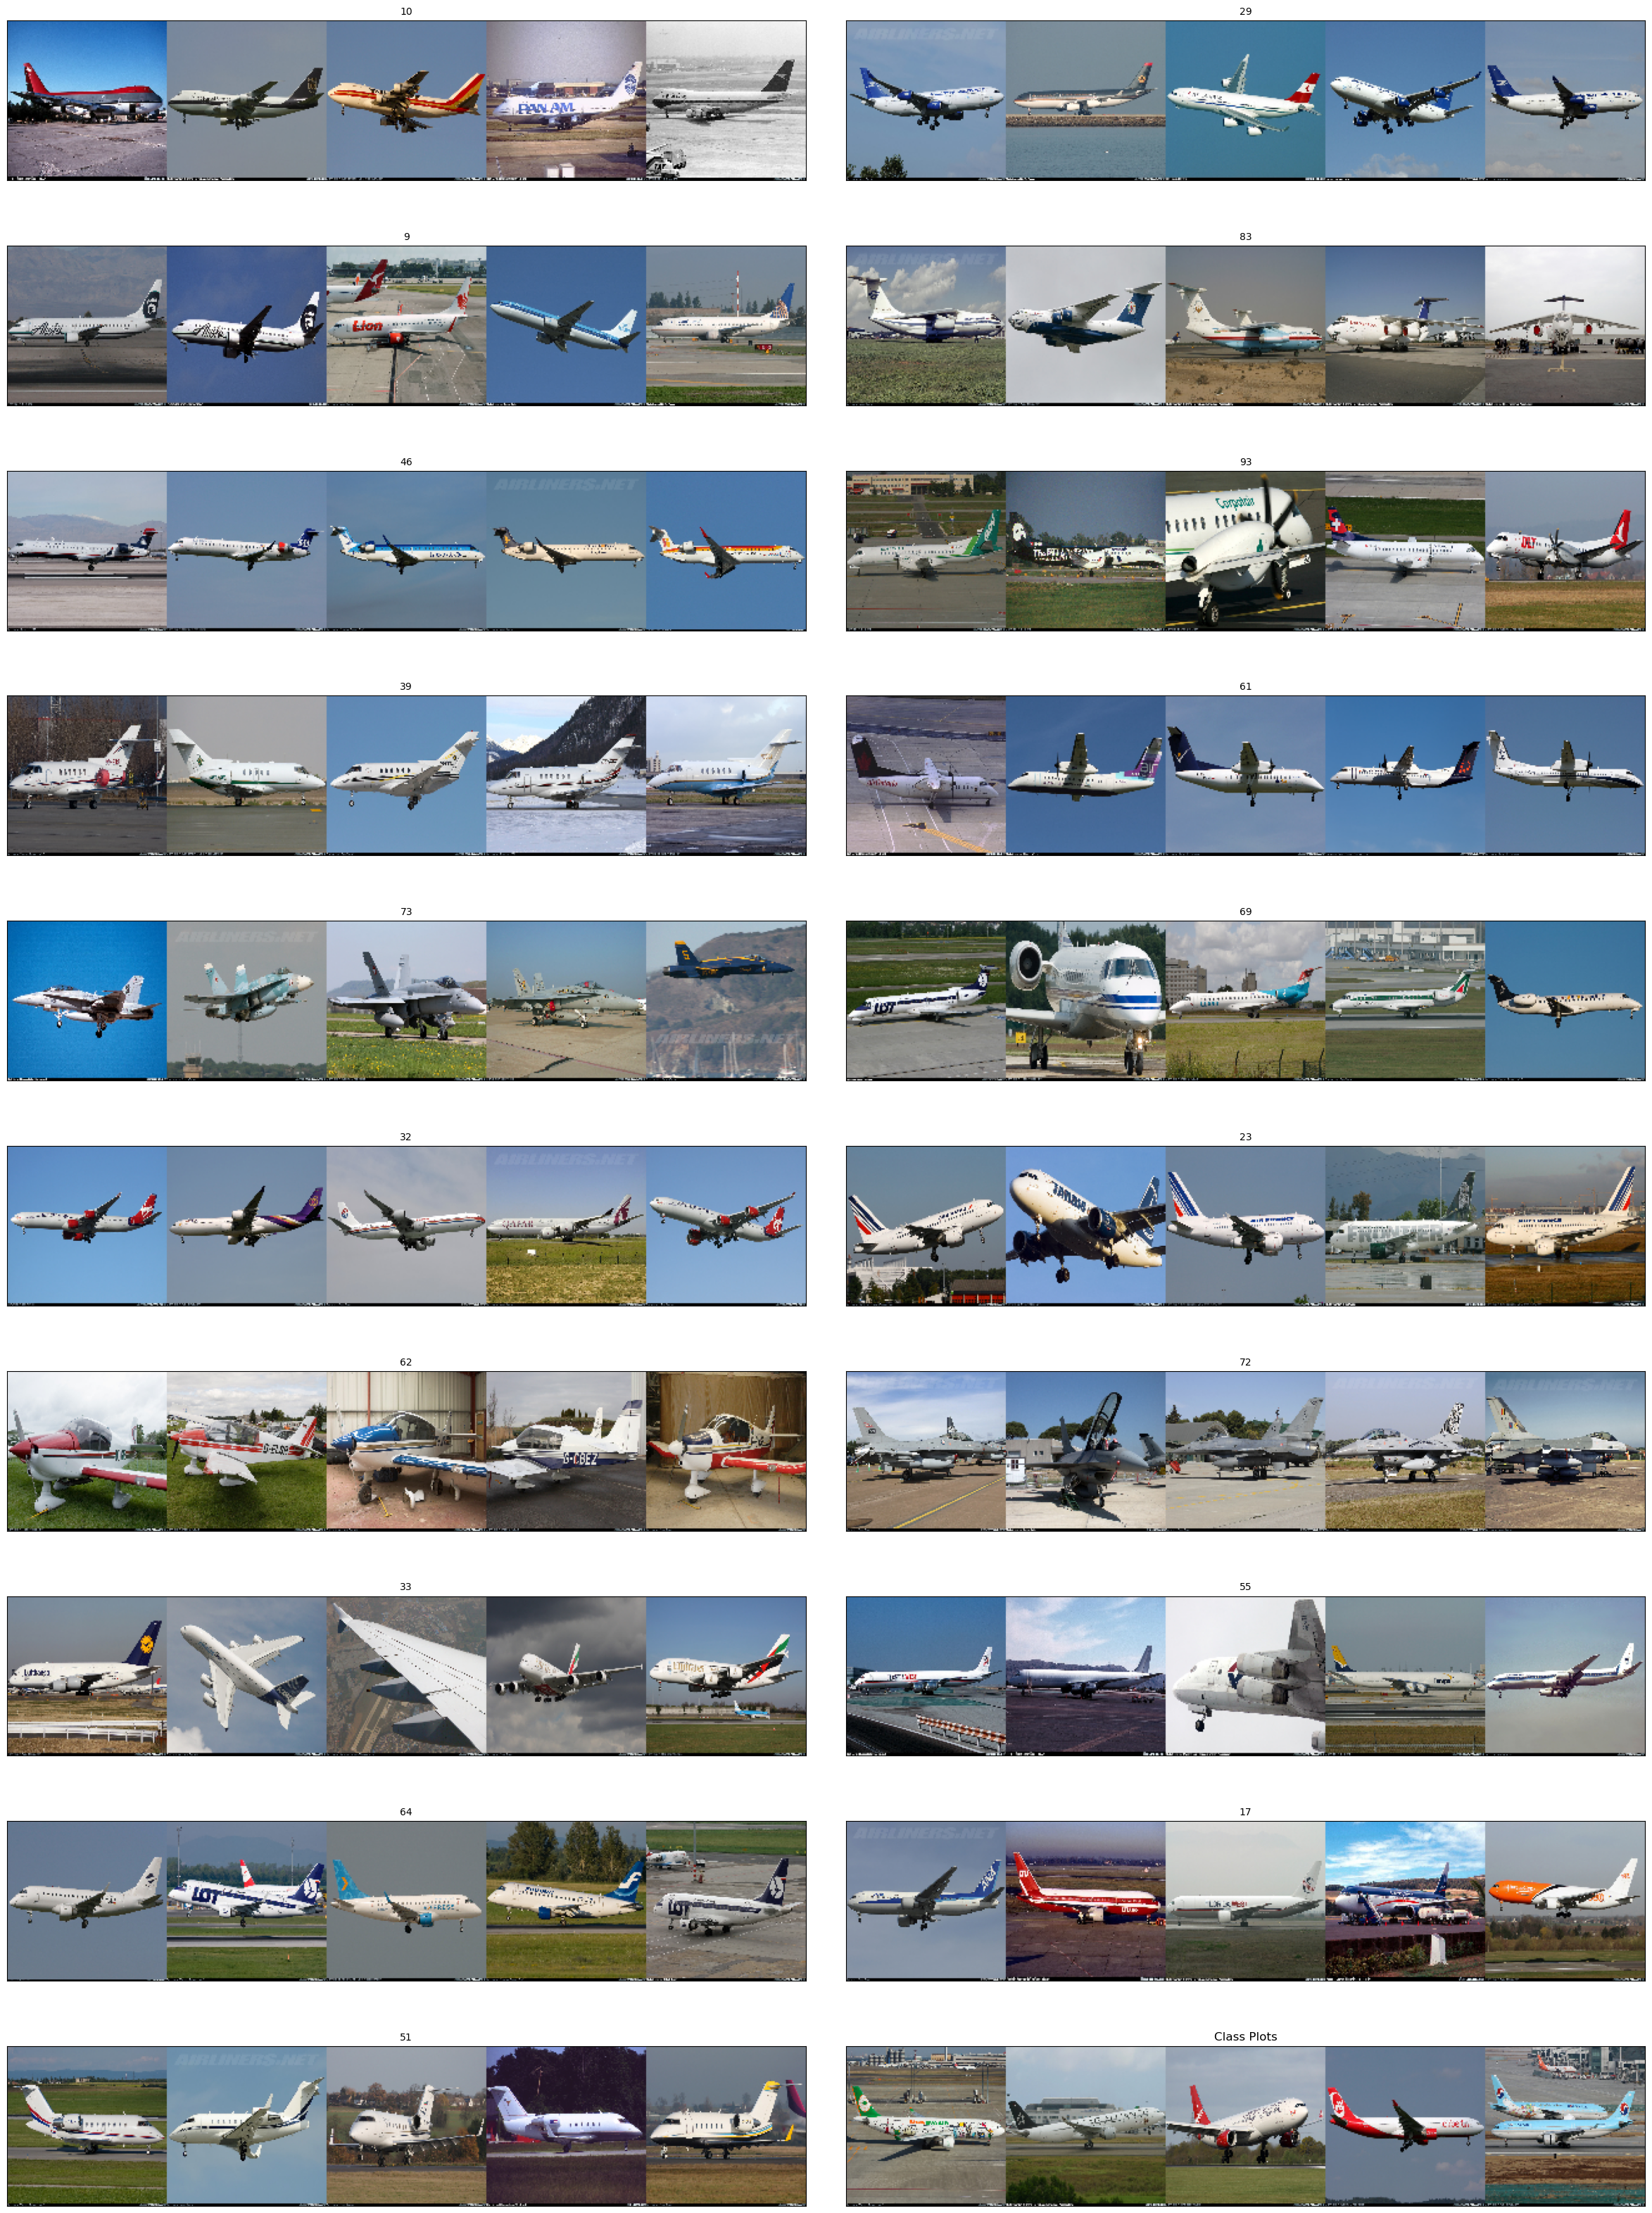

In [9]:
plot_plane_data_classes(df_train, img_dir)

# You can use the following code to get more images

# plot_plane_data_classes(df_train, img_dir, num_classes=10, img_size=(24, 32))
# plot_plane_data_classes(df_train, img_dir, num_classes=50, img_size=(24, 32))
# plot_plane_data_classes(df_train, img_dir, num_classes=100, img_size=(24, 32))

Check the balancing in the dataset

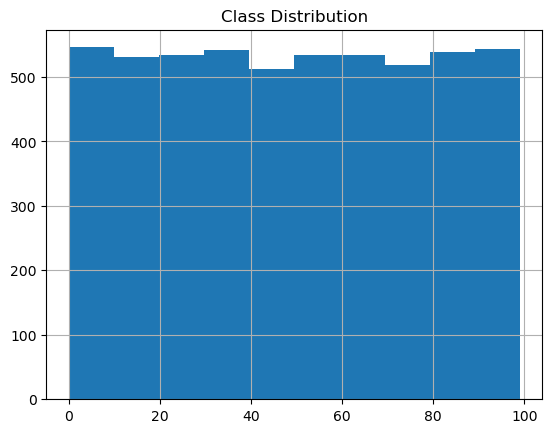

In [10]:
check_dataset_balancing(df_train)

### Explore and Visualize

Validation Data

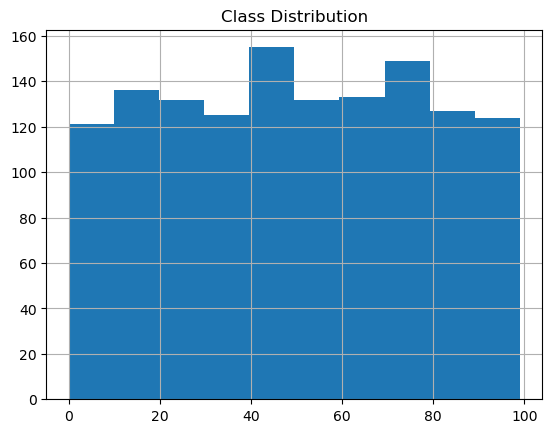

In [11]:
# plot_plane_data_classes(df_valid, img_dir)

check_dataset_balancing(df_valid)

### Explore and Visualize

Testing Data

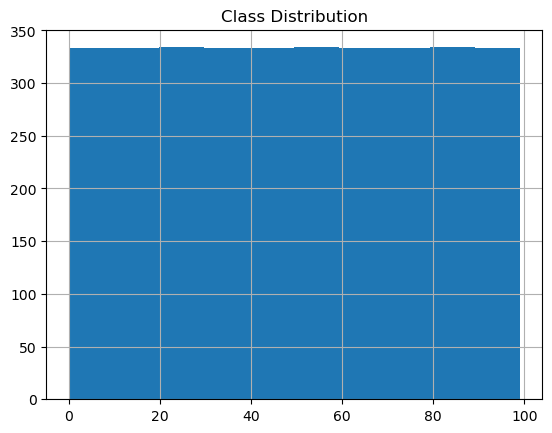

In [12]:
# plot_plane_data_classes(df_test, img_dir)

check_dataset_balancing(df_test)

### Inference from plots:

- Some of the images are black and white
- The data is uniformly distributed among the class labels

## Dataset Creation

The template provides a wrapper on top of a torch Dataset.

The user is responsible to create their own dataset and load it in PyTorch.

The `Data` class inherits from the `torch.utils.data.Dataset` class. It implements the `__len__` and the `__getitem__` functions. The user must implement the `get_input`, `get_label` and `apply_transform` functions, which define how the input and the labels can be obtained from a `pd.core.frame.DataFrame`

In [13]:
# Import Data from the template
from wcd_project_template.data import Data

In [14]:
class DataClassification(Data):
    def __init__(
            self,
            df,
            config_data: dict,
            transform: Optional[A.Compose] = None
        ):
        super().__init__(df, config_data, transform)

    def get_input(self, row):
        """gets the input from the df row

        Returns:
            np.ndarray: the image
        """
        input_path = os.path.join(self.root_dir, row['filename'])
        input = cv2.imread(input_path)
        input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
        return input

    def get_label(self, row):
        """gets the label from the df row

        Returns:
            Union[np.ndarray, int]: the label
        """
        label = row['Labels']
        return label

    def apply_transform(self, input, label):
        """applies the transformation on both the image and the label respectively. For classification, we do not need to apply any transformation on the label.

        Returns:
            Tuple[np.ndarray, int, torch.Tensor]: the transformed images and labels
        """
        input = self.transform(image=input)['image']
        return input, label

### How to create your own Dataset

You need to define the `__init__` and `__getitem__` methods according to `torch.utils.data.Dataset`. Then an additional `get_dataloader` method needs to be defined which gets any dataloader

In [15]:
# from torch.utils.data import Dataset, DataLoader
# from wcd_project_template.data import Data

# class CustomDataset(Dataset):
#     def __init__(self, config, **kwargs):
#         """__init__ method according to torch.utils.data.Dataset

#         Args:
#             config (dict): dict containing important config variables
#         """
#         self.config = config
#         ...
    
#     def __getitem__(self, idx):
#         """__getitem__ method according to torch.utils.data.Dataset

#         Args:
#             idx (int):
#         """
#         ...

#     def __len__(self):
#         ...
        
#     def get_dataloader(self):
#         """returns the dataloader on self

#         Returns:
#             Iterable: The dataloader
#         """
#         return DataLoader(self, **self.config['dataloader'])

### Define the Transforms

##### We will use the Albumentations Library for transforms
https://albumentations.ai/docs/

##### Selected Transforms:
- Resize
- Horizontal Flip
- GridDistortion
- RandomBrightnessContrast
- GaussNoise
- Normalize according to Imagenet Mean and Std
- Convert to Tensor

In [16]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Train Transforms
transforms_train = A.Compose(
    [
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),
        A.GridDistortion(p=0.2),
        A.RandomBrightnessContrast((0,0.5),(0,0.5)),
        A.GaussNoise(p=0.8),
        A.Normalize(
            mean=mean.tolist(),
            std=std.tolist(),
        ),
        ToTensorV2(),
    ],
)

# Validation Transforms
# Note: In validation transforms, we do not add the Horizontal Flip transform
transforms_valid = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(
            mean=mean.tolist(),
            std=std.tolist(),
        ),
        ToTensorV2(),
    ],
)

# Validation Inverse Transforms
# This essentially does an unnormalize on the image.
# We can use this transformation to get the original
# image back after applying the transforms to it
transforms_valid_inverse = A.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

The `Data` configuration consists of the `root_dir` to specify where the images are present. Then it consists of a `dataloader` where you can specify the kwargs for `torch.utils.data.DataLoader`

In [17]:
# Training Data config
config_dataset_train = {
    'root_dir': img_dir,
    'dataloader': {
        'batch_size': 32,
        'shuffle': True,
        'num_workers': 4
    },
}

# Validation data config
config_dataset_valid = {
    'root_dir': img_dir,
    'dataloader': {
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 4
    },
}

### Creating the Datasets

In [18]:
# Training Data
# Training data will use training data, config and transform
data_train = DataClassification(
    df_train,
    config_dataset_train,
    transform=transforms_train
)
# Validation Data
# Validation data will use validation data, config and transform
data_valid = DataClassification(
    df_valid,
    config_dataset_valid,
    transform=transforms_valid
)
# Testing Data
# Testing data will use testing data along with
# validation config and transform
data_test = DataClassification(
    df_test,
    config_dataset_valid,
    transform=transforms_valid
)

Checking what the data looks like

In [20]:
data_train[0]

(tensor([[[-0.1828, -0.0801, -0.1314,  ..., -0.2342, -0.1314, -0.2513],
          [-0.0801, -0.0287, -0.1486,  ..., -0.1314, -0.1999, -0.3198],
          [ 0.0227, -0.0801, -0.1828,  ..., -0.1828, -0.2342, -0.2171],
          ...,
          [-2.1179, -2.1179, -2.1008,  ..., -2.1008, -2.1179, -0.3883],
          [-2.1179, -2.1179, -2.0494,  ..., -0.7479, -0.7137, -0.9705],
          [-2.1008, -2.0323, -2.1179,  ..., -2.1179, -2.0494, -2.1179]],
 
         [[ 0.4853,  0.5553,  0.2927,  ...,  0.4853,  0.4153,  0.4853],
          [ 0.6078,  0.5028,  0.5728,  ...,  0.3277,  0.4153,  0.4328],
          [ 0.4853,  0.5028,  0.3102,  ...,  0.3803,  0.3277,  0.3452],
          ...,
          [-2.0357, -1.9132, -1.8957,  ..., -2.0357, -1.8431,  0.1001],
          [-2.0357, -1.9307, -2.0357,  ..., -0.6176, -0.3550, -0.8627],
          [-2.0357, -2.0357, -1.8957,  ..., -2.0357, -1.9657, -2.0357]],
 
         [[ 1.4200,  1.4374,  1.3154,  ...,  1.4897,  1.4897,  1.4025],
          [ 1.4722,  1.2980,

## DL Model

---

The template provides a wrapper on top of a torch model. The template provides the usage of 3 different libraries:
- `timm`, `segmentation-models-pytorch` and `torchvision.detection`

For Classification Purposes:
- timm
    - [Github and Documentation](https://github.com/huggingface/pytorch-image-models/tree/main)
    - comprehensive list of encoders or classification models,
    - Ex: Resnet, ViT, Mobilenet, etc
    - The timm module takes care of modifying the final classification layer.

This library contains hundreds of pretrained models including resnet till **vision transformers**

In [21]:
# Import Model from the template
from wcd_project_template.model import Model

The `Model` configuration consists of the `model_hyperparameters` to specify the parameters of the model. Then it consists of a `weights_path` where you can load pretrained model_weights from. Finally a `freeze_layer` which specifies the layers you want to freeze (perform no backpropagation on)

Check out: https://timm.fast.ai/create_model

In [22]:
config_model = {
    'model_hyperparameters':{
        'model_name': 'resnet101',
        'pretrained': True,
        'in_chans': 3,
        'num_classes': 100
    },
    'weights_path': None,
    'freeze_layers': [],
}

model_ = timm.create_model(**config_model['model_hyperparameters'])
model = Model(model_, config_model)

done loading model


In [23]:
model.model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [24]:
# List all timm models
timm.list_models(pretrained=True)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

### How to create your own Model

In [25]:
# import torch.nn as nn
# from wcd_project_template.model import Model

# class CustomModel(nn.Module):
#     def __init__(self, config):
#         self.config = config
#         ...
        
#     def forward(self, x):
#         ...
        
# config={
#     'model_hyperparameters': {},
#     ...
# }
# model_ = CustomModel(config['model_hyperparameters'])
# model = Model(model_, config)

## Model Training

---

The template provides you with a `ModelEngine` class. This class is responsible for supervised model training and evaluation. The code for training or evaluating the model is generally the same for every model. The components that change are the `Loss`, `Metric` and `Optimizer`.
- Loss
    - The loss function can be imported from any library
    - It can also be a custom loss function as seen [here](https://discuss.pytorch.org/t/custom-loss-functions/29387/2)
- Metric
    - Any metric can be used only from the library `torchmetrics`.
    - This library essentially contains all possible metrics
    - Options for a custom metric are also provided [here](https://lightning.ai/docs/torchmetrics/stable/pages/implement.html)
- Optimizer
    - The optimizer must be from the `torch.optim` module.
    - Any optimizer can be selected
    - Options for a custom optimizer as seen [here](https://stackoverflow.com/questions/76113195/custom-optimizer-in-pytorch-or-tensorflow-2-12-0). Look at the answer by 
    > Michal

In [26]:
# Import ModelEngine from the template
from wcd_project_template.model_engine import ModelEngine

Create the Model Engine

In [27]:
engine = ModelEngine('cuda')

The Model Engine config consists of the training parameters like `num_epochs`, then it contains sections where you can modify the `criterion`, `metric` and `optimizer`

The `name` parameter is a string corresponding to the import string of the Class. Except for the Optimizer, where it is the optimizer name

The `config` is the kwargs for the Class imported from the `name` parameter



In [28]:
config_training = {
    'num_epochs': 30,
    'optimizer': {
        'name': 'Adam',
        'config': {
            'lr': 0.001,
            'weight_decay': 1e-5
        },
    },
    'criterion': {
        'name': 'torch.nn.CrossEntropyLoss',
        'config': {},
    },
    'metric':{
        'name': 'torchmetrics.Accuracy',
        'config':{
            'task': 'multiclass',
            'num_classes': 100,
        }
    }
}

config_evaluation = {
    'criterion': {
        'name': 'torch.nn.CrossEntropyLoss',
        'config': {},
    },
    'metric':{
        'name': 'torchmetrics.Accuracy',
        'config':{
            'task': 'multiclass',
            'num_classes': 100,
        }
    }
}

In [29]:
trained_model, training_meta_data = engine.train(
    model,
    data_train,
    data_valid,
    config_training,
    config_evaluation
)

Total Training Samples:  5333


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch-1: ===========================================
Training: ===========            
Loss: 4.100456670372786,            
Metrics: {'MulticlassAccuracy': np.float32(0.06140398)},            
Time: 93.47035044400036 seconds
Validation: =========            
Loss = 3.0212137699127197,            
Metrics: {'MulticlassAccuracy': array(0.16566716, dtype=float32)},            
Time: 8.678053345998705 seconds

Epoch-2: ===========================================
Training: ===========            
Loss: 1.948855495024584,            
Metrics: {'MulticlassAccuracy': np.float32(0.4132271)},            
Time: 93.49768912199943 seconds
Validation: =========            
Loss = 1.4920886754989624,            
Metrics: {'MulticlassAccuracy': array(0.5037481, dtype=float32)},            
Time: 8.69740997900044 seconds

Epoch-3: ===========================================
Training: ===========            
Loss: 1.0944821913085299,            
Metrics: {'MulticlassAccuracy': np.float32(0.6400324)},   

### Training Plots

#### Loss plot

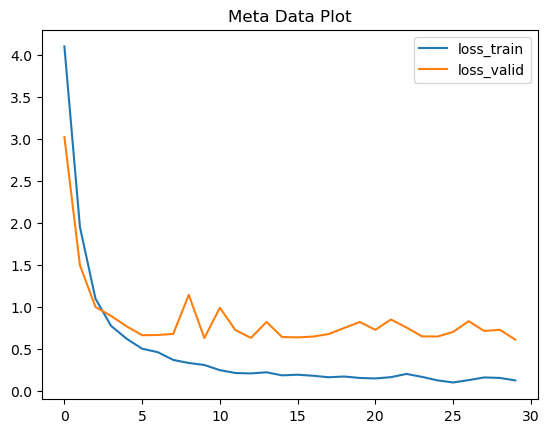

In [30]:
engine.plot(training_meta_data, ['loss_train', 'loss_valid'])

#### Metric Plot

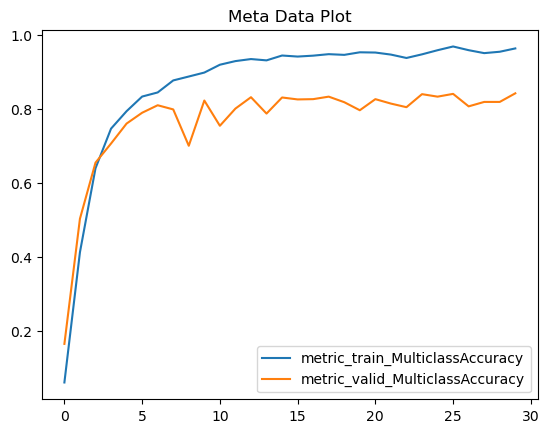

In [31]:
engine.plot(training_meta_data, ['metric_train', 'metric_valid'])

#### Save the trained model

In [32]:
torch.save(trained_model, 'classification_model.pth')

#### Load a previously trained model

In [33]:
trained_model = torch.load('classification_model.pth')

/tmp/ipykernel_148176/1789792777.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model = torch.load('classification_model.pth')


## Model Evaluation

---

The model can be evaluated similar to the training method. By specifying the trained_model, data_test and the config_evaluation

In [34]:
engine.evaluate(
    trained_model,
    data_test,
    config_evaluation
)

(array(0.6774531, dtype=float32),
 {'MulticlassAccuracy': array(0.83738375, dtype=float32)})

We can see that the model has a 83.73% accuracy on the Test Set

---
---